In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import talib as ta

from data import BinanceDataHandlerBacktest
try:
    import Queue as queue
except ImportError:
    import queue

In [12]:
# Load OHLCV data using the backtest uploader 

events=queue.Queue()
symbols=['BTC/USDT']
start_date='2023-04-06 00:00:00'

Loader=BinanceDataHandlerBacktest(events,symbols,start_date)

data_set=Loader.data_history[symbols[0]]

df = pd.DataFrame(data_set, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

In [13]:
df.tail()

,open,high,low,close,volume
timestamp,,,,,
2023-04-06 00:17:15,28102.80,28102.80,28102.79,28102.79,0.00546
2023-04-06 00:17:16,28102.79,28102.80,28102.79,28102.80,0.02414
2023-04-06 00:17:17,28102.80,28102.80,28102.79,28102.79,0.01419
2023-04-06 00:17:18,28102.79,28102.79,28102.79,28102.79,0.03162
2023-04-06 00:17:19,28102.80,28102.80,28102.80,28102.80,0.01086


In [14]:
# Add technical indicators as features

df['sma20'] = df['close'].rolling(20).mean()
df['sma50'] = df['close'].rolling(50).mean()
df['rsi14'] = ta.RSI(df['close'], timeperiod=14)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Define buy/sell labels based on the strategy
df['buy_signal'] = np.where((df['sma20'] > df['sma50']) & (df['rsi14'] < 30) & (df['macd'] > df['macdsignal']), 1, 0)
df['sell_signal'] = np.where((df['sma20'] < df['sma50']) & (df['rsi14'] > 70) & (df['macd'] < df['macdsignal']), 1, 0)

In [15]:
# Clean data by droping empty rows
df=df.dropna()

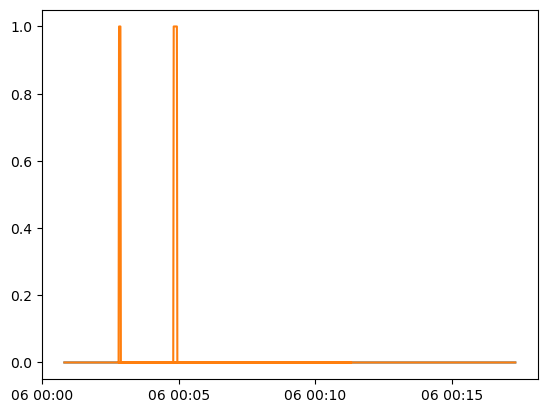

In [16]:
# Some visualisation
plt.plot(df['buy_signal'])
plt.plot(df['sell_signal'])
plt.show()

In [17]:
# Prepare data for machine learning
X = df[['open', 'high', 'low', 'close', 'volume', 'sma20', 'sma50', 'rsi14', 'macd', 'macdsignal', 'macdhist']].values
yb = df['buy_signal'].values
ys = df['buy_signal'].values


In [18]:
# Split data into training and testing sets
X_train, X_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2, random_state=42)
X_train, X_test, ys_train, ys_test = train_test_split(X, ys, test_size=0.2, random_state=42)

In [19]:

# Train Random Forest classifier
rfb = RandomForestClassifier(n_estimators=100, random_state=42)
rfb.fit(X_train, yb_train)

rfs = RandomForestClassifier(n_estimators=100, random_state=42)
rfs.fit(X_train, ys_train)

# Evaluate performance on testing set
yb_pred = rfb.predict(X_test)
accuracy = accuracy_score(yb_test, yb_pred)
print('Buy signal Model Accuracy:', accuracy)

ys_pred = rfs.predict(X_test)
accuracy = accuracy_score(ys_test, ys_pred)
print('Sell signal Model Accuracy:', accuracy)


Buy signal Model Accuracy: 1.0
Sell signal Model Accuracy: 1.0


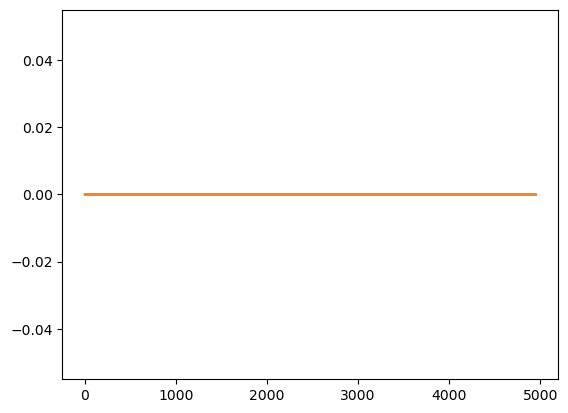

In [20]:
plt.plot(rfb.predict(X))
plt.plot(yb)

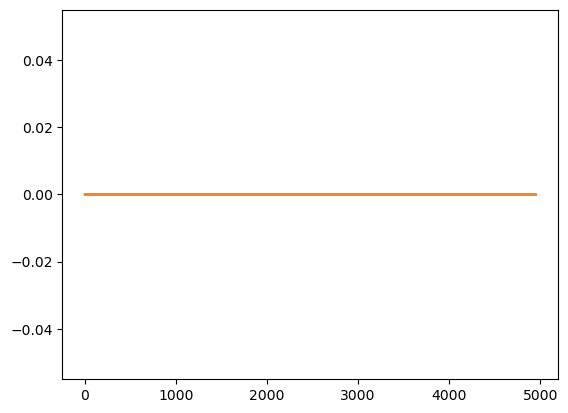

In [21]:
plt.plot(rfs.predict(X))
plt.plot(ys)

In [8]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connect to the exchange
exchange = ccxt.binance()
ohlcv_data = exchange.fetch_ohlcv('BTC/USDT', timeframe='1d')
depth_data = exchange.fetch_order_book('BTC/USDT')

# Clean and preprocess the data
df = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Clean and preprocess the data
dfdpbid = pd.DataFrame(depth_data['bids'], columns=['bid_price', 'bid_volume'])
dfdpask=pd.DataFrame(depth_data['asks'], columns=['ask_price', 'ask_volume'])
dfdp=pd.concat([dfdpbid, dfdpask], axis=1)


<AxesSubplot:>

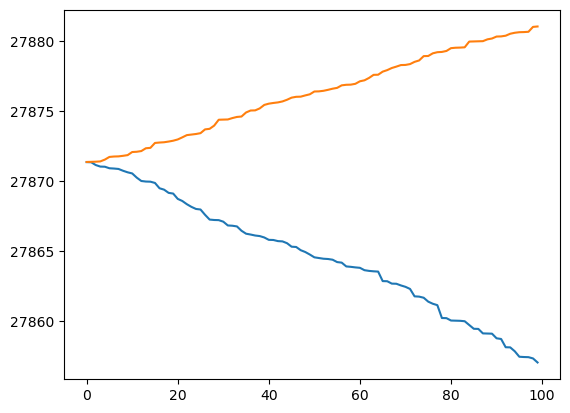

In [14]:
dfdp['bid_price'].plot()
dfdp['ask_price'].plot()

In [ ]:

df = df.set_index('timestamp')
df['mid_price'] = (df['bid'] + df['ask']) / 2
df['log_returns'] = np.log(df['mid_price']).diff()

# Calculate technical indicators
df['sma_20'] = df['mid_price'].rolling(20).mean()
df['sma_50'] = df['mid_price'].rolling(50).mean()
df['upper_band'], df['middle_band'], df['lower_band'] = ta.bollinger_hband(df['mid_price'], window=20, window_dev=2)
df['rsi'] = ta.rsi(df['mid_price'], window=14)

# Develop the trading strategy
df['signal'] = 0
df.loc[df['mid_price'] > df['upper_band'], 'signal'] = -1
df.loc[df['mid_price'] < df['lower_band'], 'signal'] = 1
df['position'] = df['signal'].diff()

# Backtest the strategy
df['strategy_returns'] = df['position'].shift(1) * df['log_returns']
df['cumulative_returns'] = df['strategy_returns'].cumsum()
df['cumulative_returns'].plot()

